<a href="https://colab.research.google.com/github/thedstrat/Machine-Learning-Python-Projects/blob/master/ImagePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Image Classification using a CNN pretrained with ImageNet weights. Pull and classify images directly from Google Images.

In [0]:
#Reload all modules in case colab has timed out
%reload_ext autoreload
%autoreload 2

In [0]:
!pip install google_images_download #Install Google Image Downloader module.

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate 
from google.colab import drive
import os
from google_images_download import google_images_download 

In [0]:
bs = 64 #what was this for again?

In [0]:
#Mount Drive and show the directory
drive.mount('/content/drive')
!ls "/content/drive/My Drive/ColabNotebooks/Fastai_1/Images"

In [0]:
#Specify the directory to download images to
path = "/content/drive/My Drive/ColabNotebooks/Fastai_1/Images/"

In [0]:
#Download images from Google Images into folder(s) in Google Drive
response = google_images_download.googleimagesdownload() #class instantiation

arguments = {'keywords': 'princess peach', 'limit': 100, 'format': 'jpg', 'size': 'medium', 'output_directory': path}
arguments2 = {'keywords': 'mario', 'limit': 100, 'format': 'jpg', 'size': 'medium', 'output_directory': path}
arguments3 = {'keywords': 'luigi', 'limit': 100, 'format': 'jpg', 'size': 'medium', 'output_directory': path}
#arguments4 = {'keywords': 'small cake', 'limit': 75, 'format': 'jpg', 'size': 'medium', 'output_directory': path}

#Run the below just once to download images and create folders
paths = response.download(arguments) #Download images and create folders
paths = response.download(arguments2)
paths = response.download(arguments3)
#paths = response.download(arguments4)

#Note: Here, you may want to manually delete incorrect images in drive.

In [0]:
#Create ImageDataBunch class to prep your images for the CNN

#Imagelist.from_folder saves a path attribute of all files that have an image suffix, split into training and cv sets randomly, give label based on the folder name, 
#apply small transformations, binds train/cv/test sets?, and normalizes all colors 

data = (ImageList.from_folder(path).split_by_rand_pct().label_from_folder().transform(get_transforms(), size=224).databunch().normalize(imagenet_stats))

In [0]:
#Show a random sample of images with their actual labels
data.show_batch(rows=3, figsize=(7,6))

In [0]:
#Train the classifier as CNN with 34 layers. The resnet34 model comes pretained w/ Imagenet weights**
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [0]:
#I think this tells us more information about each layer. Not sure if necessary...?
learn.model

In [38]:
#Fit your model using the '1 cycle' policy
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.395760,1.059865,0.571429,00:06
1,0.998027,0.448497,0.142857,00:06
2,0.738210,0.212856,0.040816,00:06
3,0.576461,0.150281,0.061225,00:06
4,0.471262,0.142341,0.061225,00:06


In [0]:
#Save the weights so that you can come back to them later
learn.save('trained_model_nintendo1', return_path = True)

#Save the learner object
learn.export('nintendo1_model.pkl')

#Note: To load later, use learn = load_learner(path) and provide path to the pkl file

## Upload and Classify a Single Image

mario tensor([2.9758e-04, 9.9761e-01, 2.0941e-03])


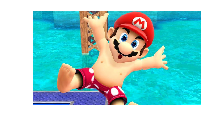

In [57]:
#Open image
img = open_image(get_image_files("/content/drive/My Drive/ColabNotebooks/Fastai_1/Images/mario/")[1]) #file name or path may vary#
img.show()

#Predict Image
pred_class, pred_idx, outputs = learn.predict(img)
print(pred_class, outputs) #outputs gives prediction for each class (peach, mario, luigi respectively)

## **Analysis**

In [0]:
#plot loss over iteration number
learn.recorder.plot_losses()

In [0]:
#Make a confusion matrix to visualize the most wrongly classified images
interp = ClassificationInterpretation.from_learner(learn)

#Returns most wrongly classified (losses) and their respective indices.
losses, indices = interp.top_losses() 
print(losses,indices)

In [0]:
#Plot most wrongly classified images
interp.plot_top_losses(9, figsize=(15,11)) #Note that the algorithm still got all of these right. Might have to increase # of photos or compare less differentiable items.

In [0]:
# Plot the confusion matrix
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
#What did the model predict incorrectly most often?
interp.most_confused(min_val=2)

# **Fine Tuning**

In [0]:
# This will unfreeze our model so that the weights in each layer may change. When did it ever become frozen? I think it only unfreezes until you run .fit_one_cycle().
learn.unfreeze()

learn.fit_one_cycle(1)

In [0]:
# Load the CNN that you saved before the analysis. Why is this not before the unfreeze?
learn.load('trained_model_all_4');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


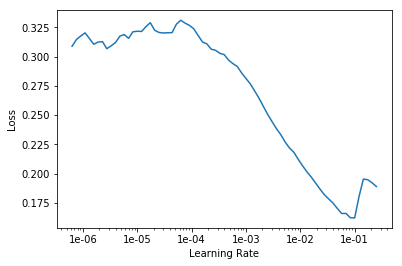

In [15]:
# Find and plot the optimal Learning Rate (alpha)
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.unfreeze() #unfreezing before this significantly improves accuracy

#Pass in the learning rates that minimize our loss using 'max_lr' below. 
learn.fit_one_cycle(3, max_lr=slice(1e-4,1e-2))

#Weird that error rate is optimized when max_lr is at highest loss, not lowest. Watch out for this method.